### Dog Breed classificatiThis notebook builds an end-to-end multi-class image classifier using TenserFlow 2.0 and TenserFlow Hub

We're going to take the following approach:

1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation 

### 1. Problem Definition

> Identifying the breed of a dog given image of a dog.

### 2. Data
The data came from kaggle's <a href='https://www.kaggle.com/c/dog-breed-identification/data'>dog breed identification competition</a>

### 3.Evaluation

The evaluation is a file with prediction probabilities for each dog breed for each test image.

### 4. Features

- Some information about the data:
We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
- There are 120 breeds of dogs (this means there are 120 different classes).
- There are around 10,000+ images in training set (these images have labels).
- There are around 10,000+ images in test set(these images have no labels, because we'll want to predict them).


### Preparing the tools
- import Tensorflow
- import TensorflowHub
- make sure we're using GPU

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF version: ',tf.__version__)
print('TF Hub version: ',hub.__version__)

TF version:  2.2.0-rc2
TF Hub version:  0.8.0


In [2]:

# Check for GPU availability
print('GPU : Available' if tf.config.list_physical_devices('GPU') else 'GPU : Not Available')

GPU : Available


### Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format.

Let's start by accessing our data and checking out thr labels.

In [3]:
import pandas as pd
labels=pd.read_csv('/content/drive/My Drive/dog-vision/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [5]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,b200db1a2dc5f3d5a6521aac2130713c,scottish_deerhound
freq,1,126


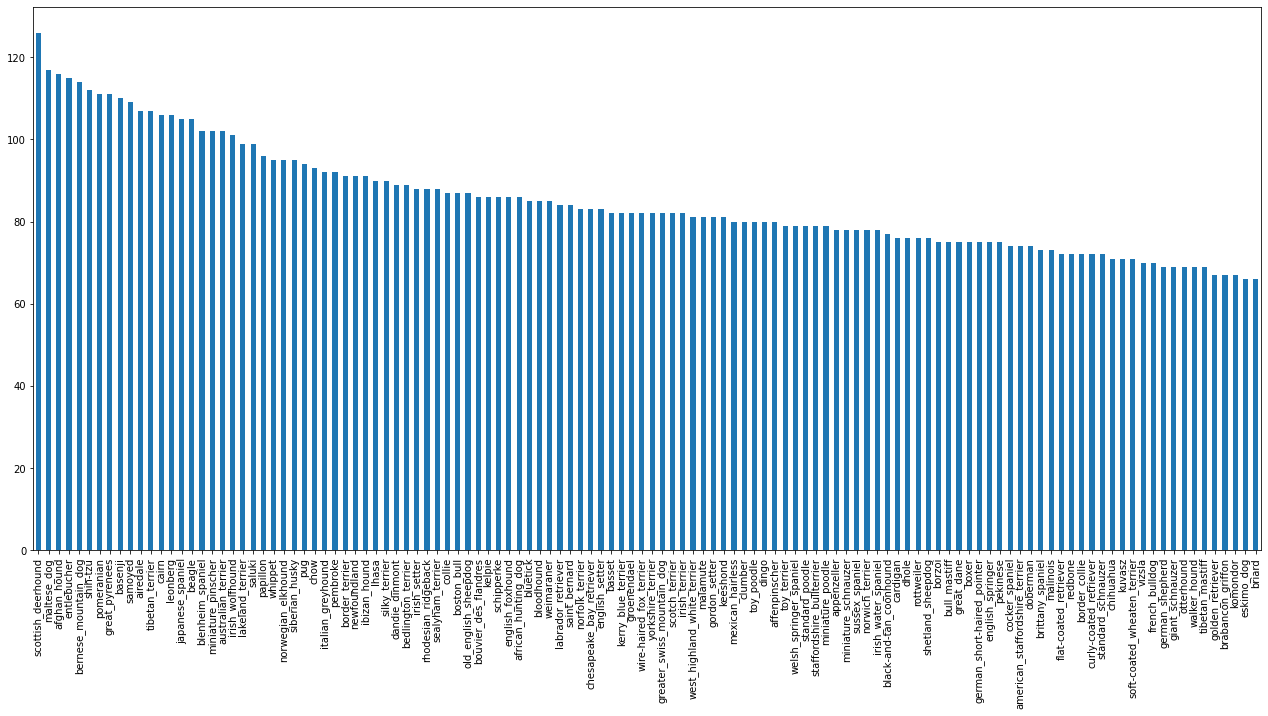

In [6]:
import matplotlib.pyplot as plt
labels['breed'].value_counts().plot.bar(figsize=(22,10))


In [7]:
labels['breed'].value_counts().max()

126

In [8]:
labels['breed'].value_counts().median()

82.0

In [9]:
labels['breed'].value_counts().min()

66

As per the Google documentation, There should be atleast 10 images per class, But 100 images per class is better.

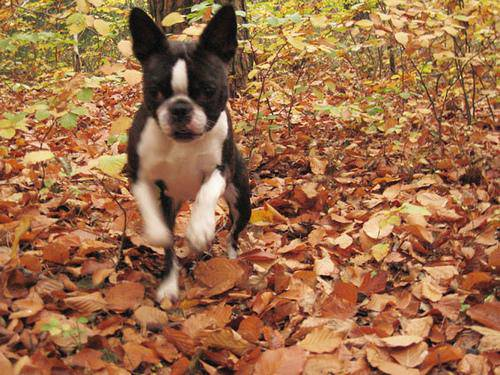

In [16]:
# Lets view an image
from IPython.display import  Image
Image('drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

### Getting all images and their labels

Lets get a list of all ourimages pathnames

In [10]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
# Create pathname from Image id

filename=['drive/My Drive/dog-vision/train/'+fname+'.jpg' for fname in labels.id]
filename[:10]

['drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [17]:
# Check whether number of filename matches number of actual image file
import os
if len(os.listdir('drive/My Drive/dog-vision/train/'))==len(filename):
  print('Number of files matched')
else:
  print('Something went wrong please try again')

Number of files matched


In [18]:
os.listdir('drive/My Drive/Dog Breed Classification/train/')[:5]

FileNotFoundError: ignored

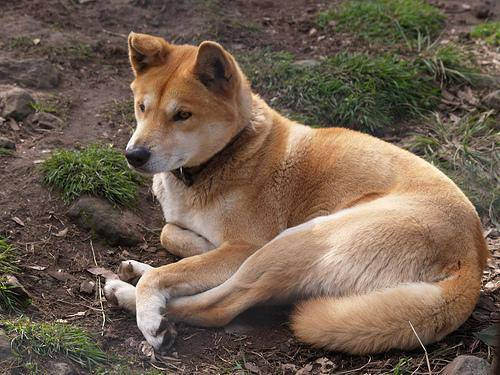

In [19]:
Image(filename[4000])

In [20]:
labels['breed'][6000]

'french_bulldog'

Since we've now got training images filepaths in a list, lets prepare our labels..

In [24]:
import numpy as np
labels_breeds=labels.breed
labels_breeds=np.array(labels_breeds)
labels_breeds

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [25]:
len(labels_breeds)

10222

In [26]:
if len(labels_breeds)==len(filename):
  print('Success')
else:
  print('failure')

Success


In [28]:
# find unique labels
unique_labels=np.unique(labels_breeds)
len(unique_labels)

120

In [29]:
# turn a single label into array of booleans
labels_breeds[0]==np.unique(labels_breeds)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [30]:
# Turn every label into array of boolean
boolean_labels=[label== unique_labels for label in labels_breeds]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [31]:
len(boolean_labels)

10222

In [32]:
# Example : Turning boolean array into integers
print(labels_breeds[0])
print(np.where(unique_labels==labels_breeds[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [33]:
print(labels_breeds[1])
print(np.where(unique_labels==labels_breeds[1]))
print(boolean_labels[1].argmax())
print(boolean_labels[1].astype(int))

dingo
(array([37]),)
37
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set

Since the dataset from kaggle does not come with validation set we are goinng to create our own

In [0]:
# Setup x and y variable
x=filename
y=boolean_labels

We are going to start of experimenting with ~1000 images and increase as needed

In [0]:
#Set number of images to use for experimenting
NUM_IMAGES=1000 #@param {type:'slider',min:1000,max:10000}

In [42]:
# lets split our data into train and validation set
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x[:NUM_IMAGES],
                                             y[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)

len(x_train),len(x_val),len(y_val),len(y_train)

(800, 200, 200, 800)

In [44]:
# Let's have a gaze at the training data
x_train[:2], y_train[:2]

(['drive/My Drive/dog-vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/dog-vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

### Preprocessing Images(turning images into tensor)

To preprocess our images into tensors we're going to write a function which does a few things

- Take an image filepath as input
- Use TensorFlow to read the file and save it to variable, image
- Turn our image (a jpg) into Tensors
- Normalize our image ( convert color channel values from 0-255 to 0-1 )
- Resize the image to be shape of (224, 224)
- Return the modefied image

Before we do, let's see what importing an image looks like

In [45]:
# Convert image to numpy array
from matplotlib.pyplot import  imread
image=imread(filename[42])
image.shape

(257, 350, 3)

In [46]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [47]:
image.min(), image.max()

(0, 255)

In [48]:
# Turn image into Tensors
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [0]:
# define image size
IMG_SIZE=224

def preprocess_image(image_path,img_size=IMG_SIZE):
  # read in image file
  image=tf.io.read_file(image_path)

  # Turn jpg image into numerical tensor  with 3 color channels
  image=tf.image.decode_jpeg(image,channels=3)

  # COnvert the color channel value fromm 0-255 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to desired value
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  # Return the image
  return image

In [51]:
tensor = tf.io.read_file(filename[0])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [52]:
# Converting image file image file to numerical tensors
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[107,  45,   0],
        [151,  91,  41],
        [177, 119,  69],
        ...,
        [175, 143,  68],
        [189, 157,  82],
        [213, 181, 106]],

       [[150,  92,  46],
        [179, 121,  75],
        [164, 110,  63],
        ...,
        [167, 136,  56],
        [171, 140,  60],
        [187, 156,  76]],

       [[150,  97,  55],
        [187, 136,  93],
        [161, 112,  69],
        ...,
        [199, 168,  78],
        [193, 162,  72],
        [200, 169,  79]],

       ...,

       [[188, 121,  66],
        [185, 118,  63],
        [182, 117,  63],
        ...,
        [213, 160, 106],
        [211, 158, 104],
        [208, 155, 101]],

       [[185, 118,  63],
        [183, 116,  61],
        [182, 117,  63],
        ...,
        [196, 144,  86],
        [199, 147,  90],
        [199, 147,  89]],

       [[181, 114,  59],
        [181, 114,  59],
        [181, 116,  62],
        ...,
        [184, 132,  7

In [53]:
# Converting from 0-255 to 0-1 makes our computing effcient
# It's called normalization
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.41960788, 0.1764706 , 0.        ],
        [0.5921569 , 0.35686275, 0.16078432],
        [0.69411767, 0.4666667 , 0.27058825],
        ...,
        [0.6862745 , 0.56078434, 0.26666668],
        [0.7411765 , 0.6156863 , 0.32156864],
        [0.8352942 , 0.70980394, 0.4156863 ]],

       [[0.5882353 , 0.36078432, 0.18039216],
        [0.7019608 , 0.47450984, 0.29411766],
        [0.6431373 , 0.43137258, 0.24705884],
        ...,
        [0.654902  , 0.53333336, 0.21960786],
        [0.67058825, 0.54901963, 0.23529413],
        [0.73333335, 0.6117647 , 0.29803923]],

       [[0.5882353 , 0.3803922 , 0.21568629],
        [0.73333335, 0.53333336, 0.3647059 ],
        [0.6313726 , 0.43921572, 0.27058825],
        ...,
        [0.7803922 , 0.65882355, 0.30588236],
        [0.7568628 , 0.63529414, 0.28235295],
        [0.7843138 , 0.6627451 , 0.30980393]],

       ...,

       [[0.7372549 , 0.47450984, 0.25882354],
        [0.72

In [56]:
preprocess_image(x[42])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01